# Receiver function example, from yaml

This example takes Malcolm's receiver function code and shows how to use that with CoFI by specifying a YAML file.

This notebook will step through everything, from compiling the receiver function fortran code, to running from the yml. 

All the code for this example is in `CoFI/user_testing/rfc`

I will assume that CoFI is installed, and resides at COFI_PATH in your local filesystem. 

In [1]:
COFI_PATH="/home/peter/personal/CoFI"   # Set this!

# Step 1: compile code into static library

The user must be responsible for compiling their code into a static library. Users might be using any number of external libraries, and might have complex build scripts/processes, so I think we have to leave the responsibility of compiling that code with them.

For Malcolm's receiver function example, this is pretty simple:

In [2]:
! cd $COFI_PATH/user_testing/rfc/code ; gfortran -c RFsubs/*.f RFsubs/*.f90 RF.f90 ; ar cr rfc.a *.o

RFsubs/qlayer.f:163:72:

  163 |            do 20 k=1,4
      |                                                                        1
RFsubs/qlayer.f:171:72:

  171 |            do 30 k=1,4
      |                                                                        1
RFsubs/qlayer.f:178:72:

  178 |            do 60 k=1,4
      |                                                                        1
RFsubs/qlayer.f:219:72:

  219 |          do 120 k=1,2
      |                                                                        1
RFsubs/qlayer.f:227:72:

  227 |          do 130 k=1,2
      |                                                                        1


So that build step has nothing to do with CoFI: it is just the normal build step you would need to go through to compile code for stand-alone execution, with the sole change that you need to compile to a shared static library rather than an executable.

# Step 2: write your CoFI interface code

This is the step that requires the most effort, and will put some people off. I do not think it can be avoided, though I do have some thoughts on how we can perhaps make it easier, which I'll discuss later in this section. 

Users who want to bring their compiled code to work with CoFI will have their code structured in a all sorts of weird and wonderful ways, and we cannot hope to integrate with that without specifying some defined interface/wrapper. The interface I have gone with so far is that they have to define the following 2 routines:
  
  * `cofi_init(...)` is guaranteed to be called once when the user library is loaded. It can take an arbitrary number of
     arguments, and returns nothing. The intention here is to allow the user to do any initialization that is required
     (e.g. reading data files, initializing global variables or common blocks, etc).
  * `cofi_misfit(...)` will be called repeatedly. It takes an arbitrary number of parameters (of arbitrary shape, so you 
     can have tensors, matrices, vectors, scalars, whatever) that specify a model, and returns a single scalar which 
     specifies how well the model fits the data (lower is better).
     
For the receiver function, the wrapper fortran code looks like this (saved as `rfcofi90.f90`):

```
! A common block to hold variables that we want to be able to
! initialize here and then use in our forward modelling.
module globvars
        integer :: npt=7
        real :: voro(7,3) ! reference model. Initialized in cofi_init
        integer :: mtype=0
        real :: fs  ! initialized in cofi_init
        real :: gauss_a ! initialized in cofi_init
        real :: water_c ! initialized in cofi_init
        real :: angle=35.0
        real :: time_shift=5.0
        real :: v60=8.043
        integer :: ndatar=626
        real :: time_obs(626)
        real :: val_obs(626)
end module


! CoFI interface code. This is called once when the RFC code is loaded by CoFI
subroutine cofi_init(fs0, gauss_a0, water_c0, true_model)
    use globvars
    implicit none
    real fs0, gauss_a0, water_c0
    real :: true_model(7,3)

    ! initialize common block variables with values passed in
    voro = true_model
    fs = fs0
    gauss_a = gauss_a0
    water_c = water_c0

    ! generate the receiver function using the reference model, and store the results in our globvars module
    ! We'll need this later to calculate misfit
    call RFcalc_nonoise(voro,mtype,fs,gauss_a,water_c,angle,time_shift,ndatar,v60,npt,time_obs,val_obs)

end


! CoFI interface code for calculating misfit of a model
! For convenience, it also returns:
!     * the signal produced by model (value_pred)
!     * the signal produced by the reference model (value_obs)
subroutine cofi_misfit(model,misfit,value_pred,value_obs)
    ! Calculate misfit against the reference model
    use globvars
    real :: model(7,3)      ! input: model to calculate misfit for
    real :: value_pred(626) ! output: result of forward model for 'model'
    real :: value_obs(626)  ! output: result of forward model for reference model
    real :: misfit          ! output: Error between predicted and actual. 
    real :: tim2(626)       ! not used
    real :: res(626)        ! residuals between predicted and observed

    call RFcalc_nonoise(model,mtype,fs,gauss_a,water_c,angle,time_shift,ndatar,v60,npt,tim2,value_pred)
    
    !  Error between predicted and actual. Here we just use sum of squares between signals, for simplicity.
    res = value_pred-val_obs
    value_obs = val_obs
    misfit = sum(res*res)
end
```

Note that these wrappers are pretty simple, but I am hoping this sort of wrapper gives them the ability to do arbitrary initialization (via `cofi_init()`) and return multiple auxilliary results from their misfit calculation, if desired. In the receiver function example above, for example, some parameters are passed into `cofi_init()` for initialization, and
some additional results (besides the scalar misfit) are returned from `cofi_misfit()`







# Step 3. Annotate your CoFI interface code


We need to compile the wrapper code from Step 2 with the underlying forward model code compiled in Step 1, and generate the shared library that will make this work with CoFI. Before we do that, we need to add F2PY annotations to our wrapper code, as described here: https://numpy.org/doc/stable/f2py/f2py.getting-started.html (under the heading 'the quick and smart way').

This means editing the wrapper code from Step 2 with the input/output parameter specifications
for `cofi_init()` and `cofi_misfit()`, like this:

```
! CoFI interface code. This is called once when the RFC code is loaded by CoFI
subroutine cofi_init(fs0, gauss_a0, water_c0, true_model)
    !F2PY INTENT(IN) :: fs
    !F2PY INTENT(IN) :: gauss_a
    !F2PY INTENT(IN) :: water_c
    !F2PY INTENT(IN) :: true_model
    !F2PY real  :: fs
    !F2PY real :: gauss_a
    !F2PY real :: water_c
    !F2PY real :: true_model(7,3)

    ....

end


! CoFI interface code for calculating misfit of a model
! For convenience, it also returns:
!     * the signal produced by model (value_pred)
!     * the signal produced by the reference model  (value_obs)
subroutine cofi_misfit(model,misfit,value_pred,value_obs)
    !F2PY INTENT(IN) :: model
    !F2PY INTENT(OUT) :: misfit
    !F2PY INTENT(OUT) :: value_pred
    !F2PY INTENT(OUT) :: value_obs
    !F2PY REAL :: model(7,3)
    !F2PY REAL :: value_pred(626)
    !F2PY REAL :: value_obs(626)
    !F2PY REAL :: misfit
    
    ....
    
end
```

So this is just doing the minimal amount of work needed to specify which parameters are input/output, and what 
type and shape they are. We have to do this if we want users to be able to pass in arbitrary inputs to these functions.
The alternative would be to be very prescriptive about the type signatures of these functions, so, for example, we could do what `scipy.optimize` does and force you to specify your model not as an arbitrary list of arbitrary shaped values (scalar, vector, matrix, tensor), but to flatten this out into a single vector x. And we could disallow output values and require that it only produces a single scalar (the misfit). With these restrictions, we could probably have CoFI annotate their wrapper code 
automatically, saving them from doing Step 3 at all. Something to think about.

# Step 4: Compile wrapper code

Now we have annotated our wrapper code, we need to compile it and link it with the static forward code produced in Step 1 into a single shared library that CoFI can work with.  

Here is the f2py call I use for the receiver function code. Note that I have edited Malcolm's RFC code to use a lapack 
routine just to demonstrate how you would link shared libraries at this stage, because this is definitely something that
users need to be able to do. 

I have not turned this into an executable shell in Jupyter because the linking breaks unless you have set everything
up correctly, and the jupyter notebook user is often not set up to have the right link paths, so please go and run 
these lines in your terminal (replacing COFI_PATH with the path to the main CoFI directory)
```
cd COFI_PATH/user_testing/rfc 
f2py -m rfc -c rfcofi.f90 -llapack code/rfc.a
```

You should see something like this as output:

```
>> f2py -m rfc -c rfcofi.f90 -llapack code/rfc.a
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "rfc" sources
f2py options: []
f2py:> /tmp/tmpitipkn74/src.linux-x86_64-3.8/rfcmodule.c
creating /tmp/tmpitipkn74/src.linux-x86_64-3.8
Reading fortran codes...
        Reading file 'rfcofi.f90' (format:free)
Post-processing...
        Block: rfc
                        Block: globvars
                        Block: cofi_init
                        Block: cofi_misfit
Post-processing (stage 2)...
        Block: rfc
                Block: unknown_interface
                        Block: globvars
                        Block: cofi_init
                        Block: cofi_misfit
Building modules...
        Building module "rfc"...
                Constructing wrapper function "cofi_init"...
                  cofi_init(fs0,gauss_a0,water_c0,true_model)
                Constructing wrapper function "cofi_misfit"...
                  misfit,value_pred,value_obs = cofi_misfit(model)
                Constructing F90 module support for "globvars"...
                  Variables: npt voro mtype fs gauss_a water_c angle time_shift v60 ndatar time_obs val_obs
        Wrote C/API module "rfc" to file "/tmp/tmpitipkn74/src.linux-x86_64-3.8/rfcmodule.c"
        Fortran 90 wrappers are saved to "/tmp/tmpitipkn74/src.linux-x86_64-3.8/rfc-f2pywrappers2.f90"
  adding '/tmp/tmpitipkn74/src.linux-x86_64-3.8/fortranobject.c' to sources.
  adding '/tmp/tmpitipkn74/src.linux-x86_64-3.8' to include_dirs.
copying /opt/conda/lib/python3.8/site-packages/numpy/f2py/src/fortranobject.c -> /tmp/tmpitipkn74/src.linux-x86_64-3.8
copying /opt/conda/lib/python3.8/site-packages/numpy/f2py/src/fortranobject.h -> /tmp/tmpitipkn74/src.linux-x86_64-3.8
  adding '/tmp/tmpitipkn74/src.linux-x86_64-3.8/rfc-f2pywrappers2.f90' to sources.
build_src: building npy-pkg config files
running build_ext
customize UnixCCompiler
C compiler: /opt/conda/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -fPIC

creating /tmp/tmp18bsb5j4/tmp
creating /tmp/tmp18bsb5j4/tmp/tmp18bsb5j4
compile options: '-MMD -MF /tmp/tmp18bsb5j4/file.c.d -c'
x86_64-conda-linux-gnu-cc: /tmp/tmp18bsb5j4/file.c
customize UnixCCompiler using build_ext
get_default_fcompiler: matching types: '['gnu95', 'intel', 'lahey', 'pg', 'nv', 'absoft', 'nag', 'vast', 'compaq', 'intele', 'intelem', 'gnu', 'g95', 'pathf95', 'nagfor', 'fujitsu']'
customize Gnu95FCompiler
Found executable /opt/conda/bin/x86_64-conda-linux-gnu-gfortran
Found executable /opt/conda/bin/x86_64-conda-linux-gnu-ld
Found executable /opt/conda/bin/x86_64-conda-linux-gnu-ar
Found executable /opt/conda/bin/x86_64-conda-linux-gnu-ranlib
customize Gnu95FCompiler
customize Gnu95FCompiler using build_ext
building 'rfc' extension
compiling C sources
C compiler: /opt/conda/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -fPIC

creating /tmp/tmpitipkn74/tmp
creating /tmp/tmpitipkn74/tmp/tmpitipkn74
creating /tmp/tmpitipkn74/tmp/tmpitipkn74/src.linux-x86_64-3.8
compile options: '-DNPY_DISABLE_OPTIMIZATION=1 -I/tmp/tmpitipkn74/src.linux-x86_64-3.8 -I/opt/conda/lib/python3.8/site-packages/numpy/core/include -I/opt/conda/include/python3.8 -c'
x86_64-conda-linux-gnu-cc: /tmp/tmpitipkn74/src.linux-x86_64-3.8/rfcmodule.c
x86_64-conda-linux-gnu-cc: /tmp/tmpitipkn74/src.linux-x86_64-3.8/fortranobject.c
In file included from /opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1944,
                 from /opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpitipkn74/src.linux-x86_64-3.8/fortranobject.h:13,
                 from /tmp/tmpitipkn74/src.linux-x86_64-3.8/fortranobject.c:2:
/opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1944,
                 from /opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpitipkn74/src.linux-x86_64-3.8/fortranobject.h:13,
                 from /tmp/tmpitipkn74/src.linux-x86_64-3.8/rfcmodule.c:16:
/opt/conda/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/tmp/tmpitipkn74/src.linux-x86_64-3.8/rfcmodule.c:136:12: warning: 'f2py_size' defined but not used [-Wunused-function]
  136 | static int f2py_size(PyArrayObject* var, ...)
      |            ^~~~~~~~~
compiling Fortran 90 module sources
Fortran f77 compiler: /opt/conda/bin/x86_64-conda-linux-gnu-gfortran -Wall -g -ffixed-form -fno-second-underscore -fPIC -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -O3 -funroll-loops
Fortran f90 compiler: /opt/conda/bin/x86_64-conda-linux-gnu-gfortran -Wall -g -fno-second-underscore -fPIC -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -O3 -funroll-loops
Fortran fix compiler: /opt/conda/bin/x86_64-conda-linux-gnu-gfortran -Wall -g -ffixed-form -fno-second-underscore -Wall -g -fno-second-underscore -fPIC -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -O3 -funroll-loops
compile options: '-I/tmp/tmpitipkn74/src.linux-x86_64-3.8 -I/opt/conda/lib/python3.8/site-packages/numpy/core/include -I/opt/conda/include/python3.8 -c'
extra options: '-J/tmp/tmpitipkn74/ -I/tmp/tmpitipkn74/'
x86_64-conda-linux-gnu-gfortran:f90: rfcofi.f90
compiling Fortran sources
Fortran f77 compiler: /opt/conda/bin/x86_64-conda-linux-gnu-gfortran -Wall -g -ffixed-form -fno-second-underscore -fPIC -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -O3 -funroll-loops
Fortran f90 compiler: /opt/conda/bin/x86_64-conda-linux-gnu-gfortran -Wall -g -fno-second-underscore -fPIC -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -O3 -funroll-loops
Fortran fix compiler: /opt/conda/bin/x86_64-conda-linux-gnu-gfortran -Wall -g -ffixed-form -fno-second-underscore -Wall -g -fno-second-underscore -fPIC -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -O3 -funroll-loops
compile options: '-I/tmp/tmpitipkn74/src.linux-x86_64-3.8 -I/opt/conda/lib/python3.8/site-packages/numpy/core/include -I/opt/conda/include/python3.8 -c'
extra options: '-J/tmp/tmpitipkn74/ -I/tmp/tmpitipkn74/'
x86_64-conda-linux-gnu-gfortran:f90: /tmp/tmpitipkn74/src.linux-x86_64-3.8/rfc-f2pywrappers2.f90
/opt/conda/bin/x86_64-conda-linux-gnu-gfortran -Wall -g -Wall -g -shared -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--disable-new-dtags -Wl,--gc-sections -Wl,-rpath,/opt/conda/lib -Wl,-rpath-link,/opt/conda/lib -L/opt/conda/lib /tmp/tmpitipkn74/tmp/tmpitipkn74/src.linux-x86_64-3.8/rfcmodule.o /tmp/tmpitipkn74/tmp/tmpitipkn74/src.linux-x86_64-3.8/fortranobject.o /tmp/tmpitipkn74/rfcofi.o /tmp/tmpitipkn74/tmp/tmpitipkn74/src.linux-x86_64-3.8/rfc-f2pywrappers2.o code/rfc.a -L/opt/conda/bin/../x86_64-conda-linux-gnu/sysroot/lib/../lib -L/opt/conda/bin/../x86_64-conda-linux-gnu/sysroot/lib/../lib -llapack -lgfortran -o ./rfc.cpython-38-x86_64-linux-gnu.so
Removing build directory /tmp/tmpitipkn74
```

# Step 5: Write your YAML input file

Rather than talk about the structure of the YAML file, which I think will change a bit as we go, I'll just show you:



In [8]:
! cat $COFI_PATH/user_testing/rfc/rfc_example.yml

name: Receiver function example
description: >
  This is a simple receiver function example. This YML file is meant to show
  how you can specify bounds on your model parameters. You can use any distribution
  defined in scipy.stats. In this example only uniform and gaussian distributions
  are used. Uniform a b means a uniform distribution between (a, a+b) and 
  norm a, b means a normal distribution with mean a and std-dev b.

# This is the specification of the model that will be optimized/inverted for.
# You are either specify values for each parameter, OR a distribution for each
# parameter. These are used as initial values at the start of the inversion, and
# (if you specify distributions) some inverters can use the distributions in 
# their sampling calculations. In this example note that some of the parameters
# are held fixed by using a uniform distribution with 0 width. 
model: &idmodel
  parameters:
    - name: earthmodel
      bounds: [
                [uniform 7 2, uniform 

I'm hoping the comments in the file are self-explanatory: the file specifies how to find the user code, what inverse solver to run (and the arguments for that), what values to pass into user_init() initialization, and the structure (and pdfs) of the model. Note here that I have specified the structure of the model by giving the probability density function for each element in the model. You can use any distribution in `scipy.stats`. This will be quite handy for inverse-solvers that require a likelihood times a prior because you can bake your prior into the model specification and the probability density can be calculated by the solver. We need to work up an example on this though, as I havent actually done any MCMC style sampling example yet.

# Step 6: Run CoFI

Next step is to point CoFI at out YAML file and run it!

In [4]:
! python3 $COFI_PATH/main.py $COFI_PATH/user_testing/rfc/rfc_example.yml

Loading user module
Calling user initialization function cofi_init() with args {'fs0': 25.0, 'gauss_a0': 2.5, 'water_c0': 0.0001, 'true_model': [[8.370596, 3.249075, 1.7], [17.23163, 3.00127, 1.7], [0.019126695, 2.509443, 1.7], [19.78145, 3.562691, 1.7], [41.73066, 4.225965, 1.7], [14.35261, 2.963322, 1.7], [49.92358, 4.586726, 1.7]]}
Saved results of inversion to Receiver function example_cofi_out.yml


This has produced an output file 'Receiver function example_cofi_out.yml'

You can then read that in to look at your results, with any yaml reader. I'll just use the python one to read it in and print some basic results. Ignore the warning, it is just python's yaml loader code being too pedantic.

In [5]:
import yaml
with open('Receiver function example_cofi_out.yml') as f:
    inversion_results = yaml.load(f)
inversion_results

<ipython-input-5-8defbc4cfcde>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  inversion_results = yaml.load(f)


{'cofi_misfit_results_for_best_model_1': [0.005992957856506109,
  0.00622069276869297,
  0.0063563245348632336,
  0.006401213351637125,
  0.006359899882227182,
  0.006239493377506733,
  0.00604909285902977,
  0.005799015052616596,
  0.005500230006873608,
  0.005163812544196844,
  0.004800444934517145,
  0.004420137498527765,
  0.004031930584460497,
  0.0036437613889575005,
  0.0032623903825879097,
  0.002893314231187105,
  0.0025408368092030287,
  0.002208125777542591,
  0.0018973583355545998,
  0.0016099055064842105,
  0.001346615026704967,
  0.001108111348003149,
  0.0008951296913437545,
  0.0007088595884852111,
  0.0005511703202500939,
  0.0004248247423674911,
  0.00033345393603667617,
  0.00028150557773187757,
  0.000273924641078338,
  0.0003157468163408339,
  0.00041165194124914706,
  0.0005653841071762145,
  0.0007793285767547786,
  0.0010540280491113663,
  0.001387972035445273,
  0.0017774526495486498,
  0.0022166697308421135,
  0.002697930671274662,
  0.003212065901607275,
  0.

So we can see we have some results packaged up, which in this case include the misfit for each model evaluated. Other inverse solvers may want to return other information.. for example MCMC may want to save out some statistics about the posterior. In general I think by reading from and dumping to YML we have a pretty flexible input/output to the different inverse solvers.

I'll do a few plots of the results just for fun.

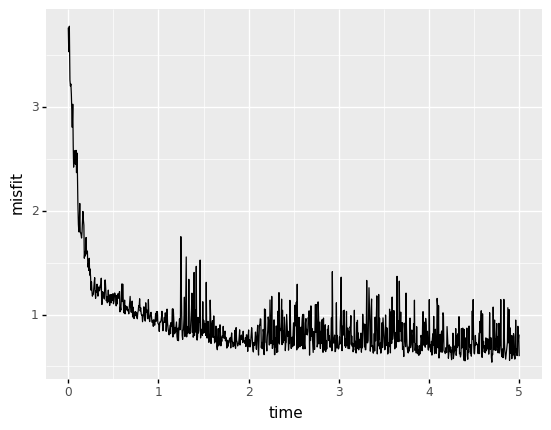

<ggplot: (8758637609141)>

In [6]:
# First plot is just a plot of misfit over time, one of the bits of information returned by the
# DumbDescent inverse solver
import pandas as pd
from plotnine import *
df = pd.DataFrame(inversion_results["misfit_by_time"], columns=["time","misfit"])
ggplot(df) + geom_line(aes(x="time", y="misfit"))

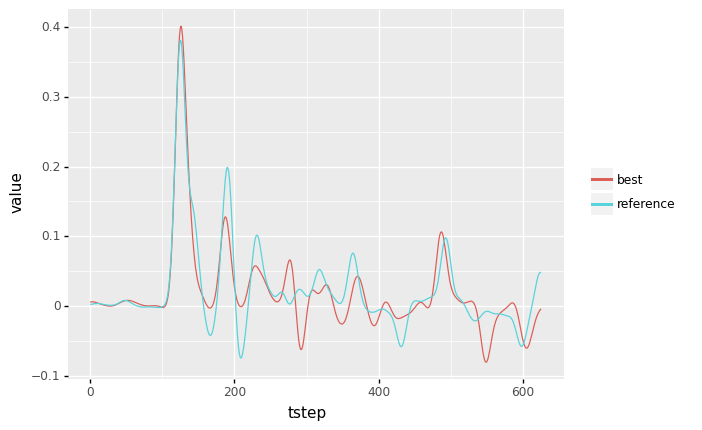

<ggplot: (8758624894202)>

In [7]:
# Now you may recall that our custom cofi_misfit() function returns not just the misfit, but also the receiver function
# for the evaluated model and the receiver function for the 'true'/reference model. Let's plot these side by side
m1 = inversion_results["cofi_misfit_results_for_best_model_1"]
m2 = inversion_results["cofi_misfit_results_for_best_model_2"]
df = pd.DataFrame(dict(tstep=range(len(m1)), best=m1, reference=m2))
ggplot(pd.melt(df, id_vars="tstep")) + geom_line(aes(x="tstep", y="value", colour="variable")) + theme(legend_title=element_blank())